# Segmentation Algorithm Benchmarking

Be sure to have gone through the main ImageProcessing notebook in PalmettoBUG before executing this one! This notebook depends on directories and masks being done there already!

## NOTE: this notebook uses libraries outside the environments file in the isoSegDenoise repo: stardist & instanseg

In [1]:
''' Install libraries not in the environment .txt file '''

# !pip install stardist instanseg-torch         
                    ## only need to run once

' Install libraries not in the environment .txt file '

In [2]:
import os
# import time  ## could consider benchmarking various algorithm speeds
import numpy as np
import pandas as pd
import tifffile as tf
import skimage

In [3]:
from stardist.matching import matching   ## similar to what the instanseg repo does, I'll use stardist's matching function to check accuracy
from instanseg import InstanSeg

### CHANGE The following directory to match an existing directory on your computer if you are testing this tutorial on your own machine!

In [4]:
my_computer_path =  "C:/Users/Default/Desktop" 

In [5]:
project_directory = f"{my_computer_path}/Example_IMC"
Tensorflow_deepcell = f"{project_directory}/masks/Example_deepcell_masks"
Torch_deepcell = f"{project_directory}/masks/deepcell"

tifffile.py (25154): Attempting to set identical low and high xlims makes transformation singular; automatically expanding.


(<Figure size 988.8x604.8 with 3 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x18b3cd93c70>)

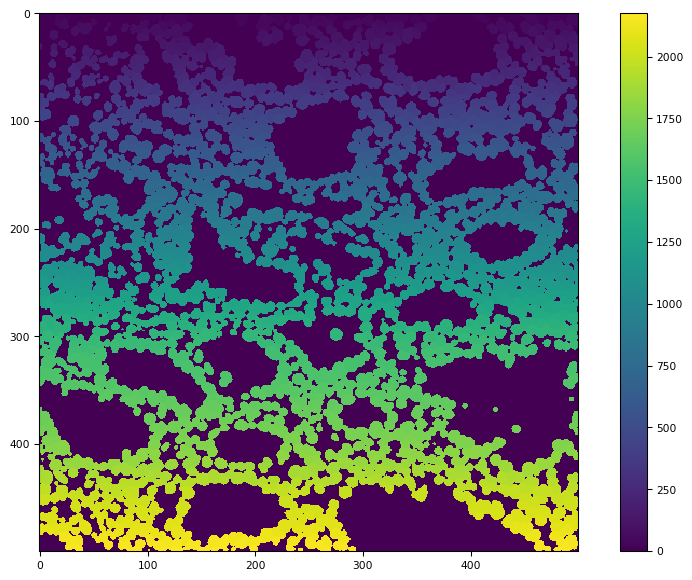

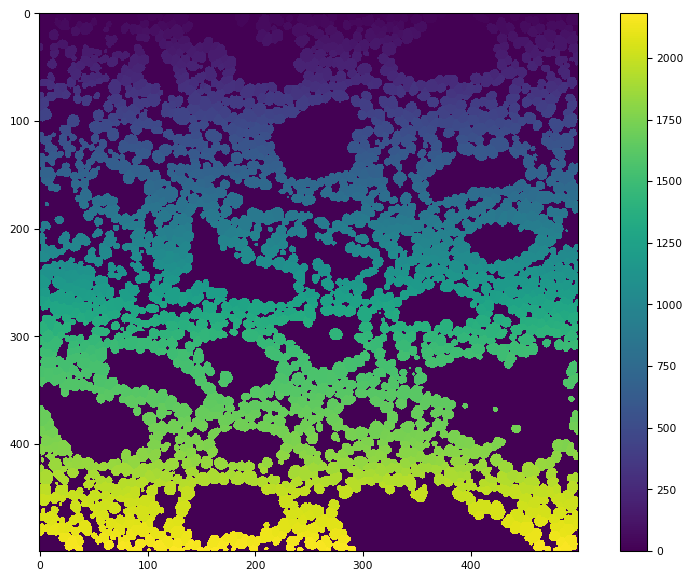

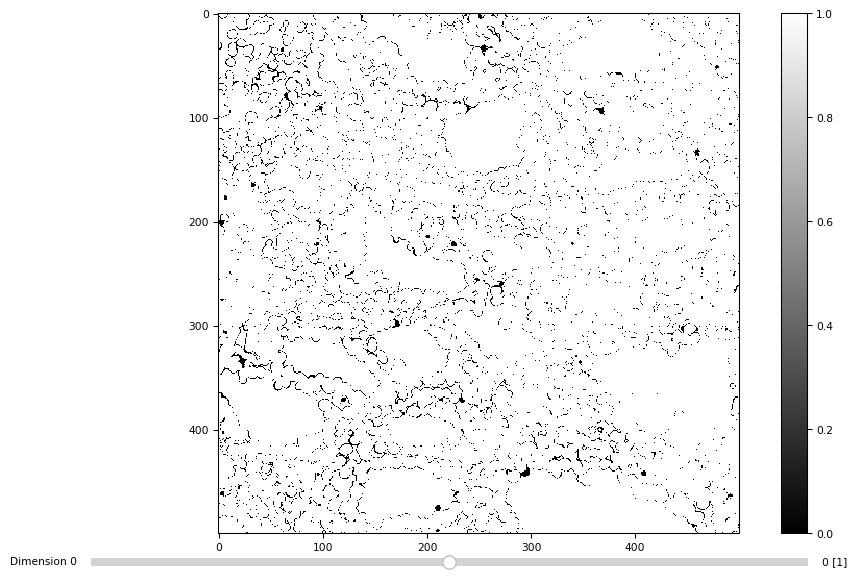

In [6]:
## Look at the Torch & Tensorflow masks

tf_masks = os.listdir(Tensorflow_deepcell)
tf_1 = tf.imread(Tensorflow_deepcell + "/" + tf_masks[0])
tf.imshow(tf_1)
torch_masks = os.listdir(Torch_deepcell)
torch_1 = tf.imread(Torch_deepcell + "/" + tf_masks[0])
tf.imshow(torch_1)
tf.imshow((torch_1 > 0) == (tf_1 > 0))

In [7]:
'''
Visually, the difference seems to be that the Torch model is typically more optimistic about the segmenting the cytoplasm (larger masks).

I don't know what a good F1 score is, and would want to test the differences in the models on the original TissueNet training dataset (not my example data),
but the variability seems fairly high between the Torch model and the original tensorflow
'''

"\nVisually, the difference seems to be that the Torch model is typically more optimistic about the segmenting the cytoplasm (larger masks).\n\nI don't know what a good F1 score is, and would want to test the differences in the models on the original TissueNet training dataset (not my example data),\nbut the variability seems fairly high between the Torch model and the original tensorflow\n"

In [8]:
torch_dir = Torch_deepcell
torch_masks = [f'{torch_dir}/{i}' for i in os.listdir(torch_dir)]

tf_dir = Tensorflow_deepcell
tf_masks = [f'{tf_dir}/{i}' for i in os.listdir(tf_dir)]

storage_df  = pd.DataFrame()
for i,ii in zip(torch_masks, tf_masks):
    matching_obj = matching(tf.imread(ii).astype('int'), tf.imread(i).astype('int'), thresh = 0.5)
    temp_df = pd.DataFrame()
    for j in matching_obj._fields:
        temp_df['file'] = i[i.rfind("/"):]
        temp_df[j] = [matching_obj._asdict()[j]]
    storage_df = pd.concat([storage_df, temp_df])

In [9]:
storage_df

,file,criterion,thresh,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality
0,/CRC_1_ROI_001.ome.tiff,iou,0.5,64,2119,58,0.970683,0.973358,0.945560,0.972018,2177,2183,0.870449,0.894275,0.869251
0,/CRC_1_ROI_002.ome.tiff,iou,0.5,485,6910,361,0.934415,0.950351,0.890923,0.942316,7271,7395,0.780563,0.821342,0.773964
0,/CRC_2_ROI_001.ome.tiff,iou,0.5,268,3171,222,0.922070,0.934571,0.866157,0.928279,3393,3439,0.773621,0.827782,0.768412
0,/CRC_2_ROI_002.ome.tiff,iou,0.5,94,1797,54,0.950291,0.970827,0.923907,0.960449,1851,1891,0.845773,0.871188,0.836732
0,/CRC_2_ROI_003.ome.tiff,iou,0.5,83,2446,119,0.967181,0.953606,0.923716,0.960346,2565,2529,0.847609,0.888846,0.853599
0,/CRC_2_ROI_004.ome.tiff,iou,0.5,158,1315,174,0.892736,0.883143,0.798421,0.887914,1489,1473,0.685371,0.776059,0.689073
0,/CRC_3_ROI_001.ome.tiff,iou,0.5,271,5306,729,0.951408,0.879205,0.841421,0.913882,6035,5577,0.753430,0.856945,0.783146
0,/CRC_3_ROI_002.ome.tiff,iou,0.5,232,5643,845,0.960511,0.869760,0.839732,0.912885,6488,5875,0.750050,0.862364,0.787240
0,/CRC_3_ROI_003.ome.tiff,iou,0.5,76,931,57,0.924528,0.942308,0.875000,0.933333,988,1007,0.789574,0.837916,0.782055
0,/CRC_3_ROI_004.ome.tiff,iou,0.5,335,4040,630,0.923429,0.865096,0.807193,0.893311,4670,4375,0.738683,0.853874,0.762775


# A Look at InstanSeg

Could use in PalmettoBUG itself, as this model is truly open-source (no non-commercial / academic restrictions on it!)

In [10]:
instan_dir = project_directory + "/masks/instanseg"
if not os.path.exists(instan_dir):
    os.mkdir(instan_dir)
instan_masks = [f'{instan_dir}/{i}' for i in os.listdir(project_directory + "/images/img")]

images = [f'{project_directory}/images/img/{i}' for i in os.listdir(project_directory + "/images/img")]

In [11]:
model = InstanSeg("fluorescence_nuclei_and_cells")

for i,ii in zip(images, instan_masks):
    image = tf.imread(i)
    image = skimage.filters.gaussian(image, channel_axis = 0)
    mask = model.eval_medium_image(image, pixel_size = 1.0, mean_threshold = -1.0, target = "cells")
    tf.imwrite(ii, np.squeeze(np.asarray(mask[0])))
    print(i)

Model fluorescence_nuclei_and_cells version 0.1.0 already downloaded in C:\Users\benca\miniforge3\envs\isd\lib\site-packages\instanseg\utils\../bioimageio_models/, loading
Requesting default device: cpu


autocast_mode.py (266): User provided device_type of 'cuda', but CUDA is not available. Disabling
  0%|                                                                                            | 0/9 [00:00<?, ?it/s]module.py (1750): Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
                                                                                                                       0.41s/it]

C:/Users/Default/Desktop/Example_IMC/images/img/CRC_1_ROI_001.ome.tiff


                                                                                                                       5.31s/it]

C:/Users/Default/Desktop/Example_IMC/images/img/CRC_1_ROI_002.ome.tiff


                                                                                                                       5.52s/it]

C:/Users/Default/Desktop/Example_IMC/images/img/CRC_2_ROI_001.ome.tiff


                                                                                                                       6.46s/it]

C:/Users/Default/Desktop/Example_IMC/images/img/CRC_2_ROI_002.ome.tiff


                                                                                                                       6.26s/it]

C:/Users/Default/Desktop/Example_IMC/images/img/CRC_2_ROI_003.ome.tiff


                                                                                                                       6.65s/it]

C:/Users/Default/Desktop/Example_IMC/images/img/CRC_2_ROI_004.ome.tiff


                                                                                                                       6.43s/it]

C:/Users/Default/Desktop/Example_IMC/images/img/CRC_3_ROI_001.ome.tiff


                                                                                                                       5.47s/it]

C:/Users/Default/Desktop/Example_IMC/images/img/CRC_3_ROI_002.ome.tiff


                                                                                                                       2.14s/it]

C:/Users/Default/Desktop/Example_IMC/images/img/CRC_3_ROI_003.ome.tiff


                                                                                                                       6.89s/it]

C:/Users/Default/Desktop/Example_IMC/images/img/CRC_3_ROI_004.ome.tiff


(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x18b4086b700>)

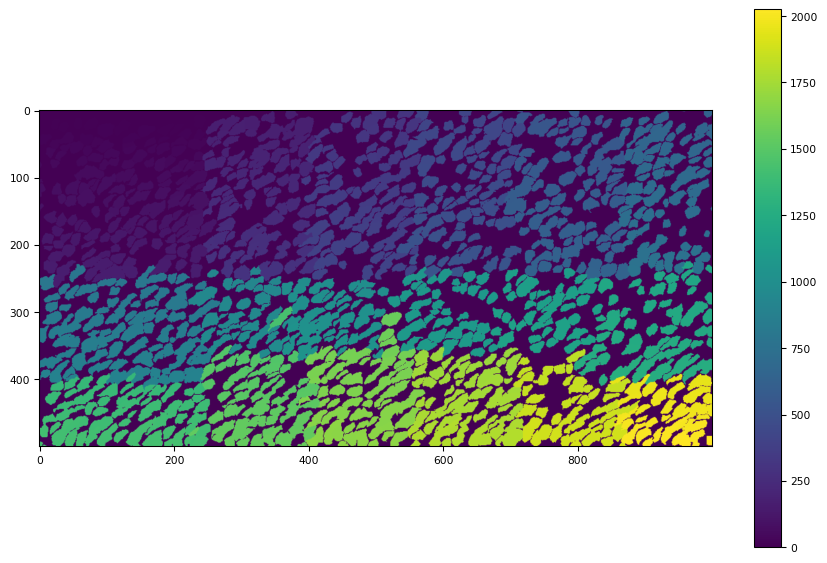

In [12]:
tf.imshow(np.array(mask[0]))

In [14]:
instan_dir = instan_dir
instan_masks = [f'{instan_dir}/{i}' for i in os.listdir(instan_dir)]

tf_masks = [f'{tf_dir}/{i}' for i in os.listdir(tf_dir)]

storage_df  = pd.DataFrame()
for i,ii in zip(instan_masks, tf_masks):
    matching_obj = matching(tf.imread(ii).astype('int'), tf.imread(i).astype('int'), thresh = 0.5)
    temp_df = pd.DataFrame()
    for j in matching_obj._fields:
        temp_df['file'] = i[i.rfind("/"):]
        temp_df[j] = [matching_obj._asdict()[j]]
    storage_df = pd.concat([storage_df, temp_df])

In [15]:
storage_df

,file,criterion,thresh,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality
0,/CRC_1_ROI_001.ome.tiff,iou,0.5,396,377,1800,0.487710,0.173174,0.146522,0.255593,2177,773,0.113038,0.652744,0.166837
0,/CRC_1_ROI_002.ome.tiff,iou,0.5,1514,664,6607,0.304867,0.091322,0.075583,0.140544,7271,2178,0.057551,0.630197,0.088570
0,/CRC_2_ROI_001.ome.tiff,iou,0.5,941,328,3065,0.258471,0.096670,0.075681,0.140712,3393,1269,0.062729,0.648905,0.091309
0,/CRC_2_ROI_002.ome.tiff,iou,0.5,449,253,1598,0.360399,0.136683,0.110000,0.198198,1851,702,0.088565,0.647957,0.128424
0,/CRC_2_ROI_003.ome.tiff,iou,0.5,457,416,2149,0.476518,0.162183,0.137657,0.242001,2565,873,0.105469,0.650306,0.157375
0,/CRC_2_ROI_004.ome.tiff,iou,0.5,311,52,1437,0.143251,0.034923,0.028889,0.056156,1489,363,0.021443,0.614020,0.034481
0,/CRC_3_ROI_001.ome.tiff,iou,0.5,1216,100,5935,0.075988,0.016570,0.013791,0.027207,6035,1316,0.010324,0.623031,0.016951
0,/CRC_3_ROI_002.ome.tiff,iou,0.5,1147,123,6365,0.096850,0.018958,0.016110,0.031709,6488,1270,0.011840,0.624552,0.019804
0,/CRC_3_ROI_003.ome.tiff,iou,0.5,268,38,950,0.124183,0.038462,0.030255,0.058733,988,306,0.024861,0.646388,0.037964
0,/CRC_3_ROI_004.ome.tiff,iou,0.5,1313,59,4611,0.043003,0.012634,0.009861,0.019530,4670,1372,0.007349,0.581674,0.011360
